# High Plains Aquifer Potentiometric Surface

This week, we are going to create a potentiometric surface for a heavily stressed portion of the High Plains Aquifer system in southwestern Kansas. 

### Import packages

This week, we are going to use four libraries that you have already seen (pandas, matplotlib, pylab, and numpy).

We are also going to use a new package, CartoPy, to do mapping. In Conda Prompt, run "conda install cartopy" before running this script. We are going to import tools to work with projections and features. 

Next, we are going to import the pykrige package, which we much install. In Conda Prompt, run "pip install pykrige". This will add pykrige to your Anaconda installation . We are going to import the Universal Kriging function to make contours.

In [1]:
!apt-get -qq install python-cartopy python3-cartopy
import cartopy

!pip install pykrige

In [0]:
# First we import a few packages that we have already used: pandas, matplotlib, pylab, numpy
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import numpy as np

# import cartopy, which we will use to map
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features


# import the UniversalKriging function from pykrige.uk 
from pykrige.uk import UniversalKriging

### Import data from the High Plains aquifer

This data is from 2013 (pre-irrigation season) for the High Plains Aquifer in Kansas. We are going to read in data from the southern portion of Kansas, where water level changes are most extreme in the state. Also add a column that calculates the head, which is the parameter that we are going to contour to make a potentiometric surface.

![HighPlains](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/hp_wlcpd15go.png)

In [0]:
# High Plains aquifer data from Kansas, import into dataframe
hp_dtw = pd.read_excel('https://github.com/dbabrams/Week6PotSurface/blob/master/highplains_ks_south.xlsx?raw=true')
# add a column for head and calculate as (land surface - depth to water)
hp_dtw = hp_dtw.join(pd.DataFrame({'heads_ft': hp_dtw['land_ftamsl']-hp_dtw['dtw_ft']}))
#print(hp_dtw)

### Conduct kriging

After importing the pykrige package, conduct a Universal Kriging. The Universal Kriging function requires the following input parameters:

<ul>
    <li>The longitude of points to be interpolated, as a numpy data array</li>
    <li>The latitude of points to be interpolated, as a numpy data array</li>
    <li>Head for each point</li>
    <li>Variogram model, assigned as "Spherical". We could also explore Gaussian, Linear, Exponential, etc.</li>
</ul>

In [0]:
# conduct the Universal Kriging, note that the output is an object that we have to work with later. 
UK = UniversalKriging(hp_dtw['long'], hp_dtw['lat'], hp_dtw['heads_ft'], variogram_model='spherical',nlags=6)

### Create a grid to plot the data

First, we need to define the range over which we are going to create out plot.

Second, we need to create the x and y coordinates for the grid (with a grid spacing of 0.1). We will also make the mesh grid, defined as X and Y.

Finally, we use the method UK.execute(), with arguments that first inform that we are creating a grid ('grid'), xpoins, and ypoints. The output of this method is the interpolated values and the variance.

Note that we also run the method z.filled(), which will fill in any missing values. We assign the fill_value as 'None'.

In [0]:
# define the area over which to plot data
minlat = min(hp_dtw['lat'])
maxlat = max(hp_dtw['lat'])
minlong = min(hp_dtw['long'])
maxlong = max(hp_dtw['long'])

# create xpoints and ypoints in space, with 0.01 spacing
xpoints = np.arange(minlong,maxlong,0.01)
ypoints = np.arange(minlat,maxlat,0.01)

# create a meshgrid with xpoints and ypoints, to be used later in the code
X,Y = np.meshgrid(xpoints,ypoints)

# calculate the interpolated grid and fill values.
z, var = UK.execute('grid', xpoints,ypoints)
z = z.filled(fill_value=None)

### Create a map

Finally, let's create a map using CartoPy with the defined extents and imported data, as well as the interpolated grid from above. First, let's just plot the points on a map. 


### Create a potentiometric surface

Repeat the code that defines the map. Next, define the contours with the method to the map object, with the following arguments:

<ul>
    <li>mesh grid X</li>
    <li>mesh grid Y</li>
    <li>Interpolated grid z</li>
    <li>Range over which to contour (2000-3000 ft works well, with an interval of 100 ft)</li>
</ul>

Next, we will label the contours using pylab.clabel, with the following arguments:

<ul>
    <li>The object defining the contours </li>
    <li>inline, which defines how labels are positioned</li>
    <li>font size</li>
    <li>label format (here we format as an integer using fmt = '%1.0f')</li>
</ul>

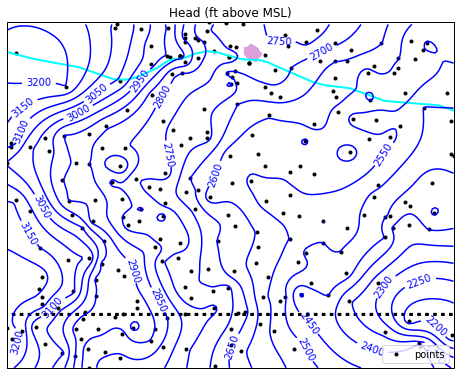

In [7]:
# https://www.naturalearthdata.com/features/

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xlim(minlong,maxlong)
ax.set_ylim(minlat,maxlat)
ax.set_title("Head (ft above MSL)")
states_provinces = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces',
    scale='50m',
    facecolor='none')	
largerivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='110m',
    facecolor='none')
smallrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines_scale_rank',
    scale='10m',
    facecolor='none')   
popplaces = cf.NaturalEarthFeature(
    category='cultural',
    name='urban_areas',
    scale='10m',
    facecolor='plum') 

ax.add_feature(popplaces,edgecolor='plum',linewidth=1.0)
ax.add_feature(largerivers,edgecolor='aqua',linewidth=2.0)
ax.add_feature(smallrivers,edgecolor='aqua',linewidth=2.0)
ax.add_feature(states_provinces, edgecolor='black', linewidth=3.0,linestyle=':')




# create contours from the interpolation
cset = plt.contour(X,Y,z,np.arange(1000, 5000, 50),colors='blue')

# contour labels
pylab.clabel(cset, inline=1, fontsize=10,fmt='%1.0f')

# plot the points that were measured
plt.scatter(hp_dtw['long'], hp_dtw['lat'], marker=".", color="black", label="points")


plt.legend(loc='lower right')
plt.title('Head (ft above MSL)')
plt.show()
